由于反卷积或上采样方式不当，之前的扩散模型有棋盘格状的伪影问题

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

# User defined libraries
from utils import other_utils
from utils import ddpm_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

## 组标准化和GeLU

批标准化会将每个卷积核通道的输出转换为标准分数。它通过计算一批输入样本的均值和标准差来实现归一化。如果批量大小太小，这种方法的效果就会很差。这里就使用组归一化：每个batch里面分组，每个组内的元素进行组标准化。

当偏置项变得非常负时，ReLU神经元会死亡，因为其输出和梯度都变为零。GELU在计算上略有代价，但它试图修复ReLU，通过模仿其形状，同时避免梯度为零的问题。
- 在这个小型的FashionMNIST实验中，不太可能遇到死神经元。但随着模型规模的增加，ReLU死亡问题就更可能出现。这里还是改一下。

In [3]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

重排池化

最大/最小/平均池化实际上是有点碰运气，很可能丢失关键信息，所以我们可以将图片分为更多的通道，然后送入`GELUConvBlock`，让神经网络自己决定如何在池化区域中加权每个值。注意这里`GELUConvBlock`的输入通道变成了`4 * in_chs`，这是因为通道数已经乘上了`p1 * p2`。

In [5]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

为了缓解棋盘格伪影问题，这里加入了多个`GELUConvBlock`。

In [6]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

UpBlock接收一个额外的输入(用于跳跃连接skip)

In [8]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip): # skip跳跃连接
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

## 时间嵌入

模型越能理解自己当前处于扩散过程的哪个时间步，就越有可能准确判断出噪声的程度。在扩散模型出现之前，这其实是NLP中常见的问题，它使用时间嵌入来实现。这里增加一个正余弦时间嵌入。

In [9]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

将`SinusoidalPositionEmbedBlock`的输出送入`EmbedBlock`中

In [11]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

## 残差连接

最后一个技巧是加入更多的残差连接。我们可以为初始卷积部分创建一个`ResidualConvBlock`，当然也可以在DownBlock和UpBlock中增加类似结构。

In [12]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [15]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777


训练模型：

Epoch 0 | step 000 Loss: 1.2498779296875 


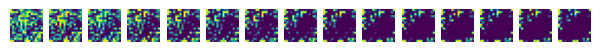

Epoch 0 | step 100 Loss: 0.1754542887210846 


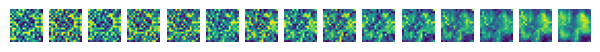

Epoch 0 | step 200 Loss: 0.14713090658187866 


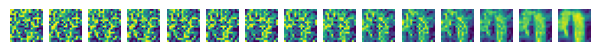

Epoch 0 | step 300 Loss: 0.12724606692790985 


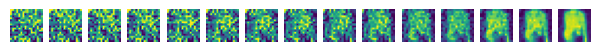

Epoch 0 | step 400 Loss: 0.1136004775762558 


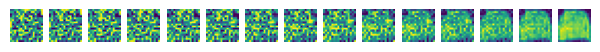

Epoch 0 | step 500 Loss: 0.10382294654846191 


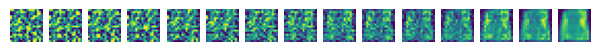

Epoch 1 | step 000 Loss: 0.11033833026885986 


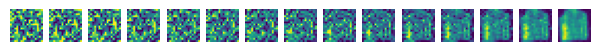

Epoch 1 | step 100 Loss: 0.13358303904533386 


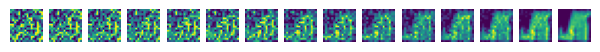

Epoch 1 | step 200 Loss: 0.10399185121059418 


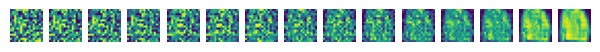

Epoch 1 | step 300 Loss: 0.1139640137553215 


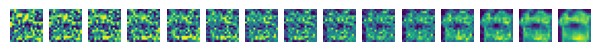

Epoch 1 | step 400 Loss: 0.1084812581539154 


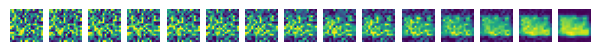

Epoch 1 | step 500 Loss: 0.1104068011045456 


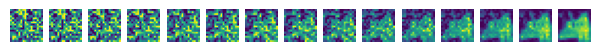

Epoch 2 | step 000 Loss: 0.11242267489433289 


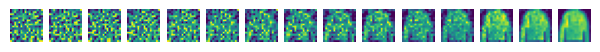

Epoch 2 | step 100 Loss: 0.11513940989971161 


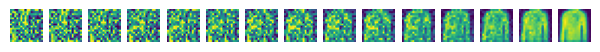

Epoch 2 | step 200 Loss: 0.09689486026763916 


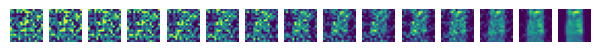

Epoch 2 | step 300 Loss: 0.10944822430610657 


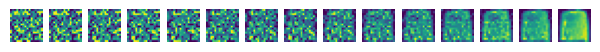

Epoch 2 | step 400 Loss: 0.10125252604484558 


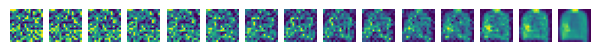

Epoch 2 | step 500 Loss: 0.0938996821641922 


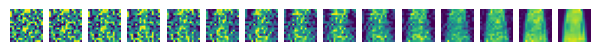

Epoch 3 | step 000 Loss: 0.09812453389167786 


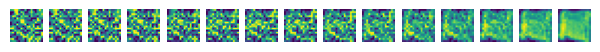

Epoch 3 | step 100 Loss: 0.08547255396842957 


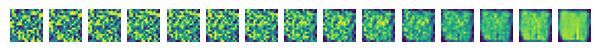

Epoch 3 | step 200 Loss: 0.07974514365196228 


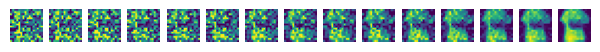

Epoch 3 | step 300 Loss: 0.0945630669593811 


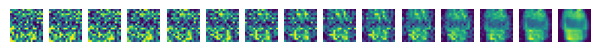

Epoch 3 | step 400 Loss: 0.10335741937160492 


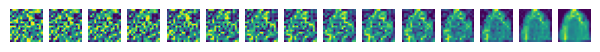

Epoch 3 | step 500 Loss: 0.09456230700016022 


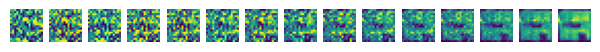

Epoch 4 | step 000 Loss: 0.10187011957168579 


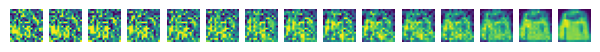

Epoch 4 | step 100 Loss: 0.08218687772750854 


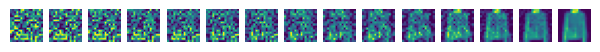

Epoch 4 | step 200 Loss: 0.10278833657503128 


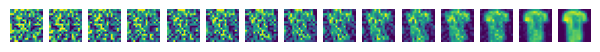

Epoch 4 | step 300 Loss: 0.09513945877552032 


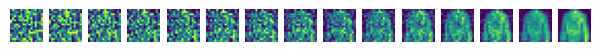

Epoch 4 | step 400 Loss: 0.09775824844837189 


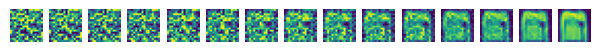

Epoch 4 | step 500 Loss: 0.11592668294906616 


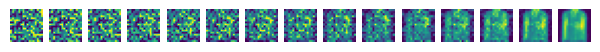

In [16]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

How about a closer look? Can you recognize a shoe, a purse, or a shirt?

<Figure size 800x800 with 0 Axes>

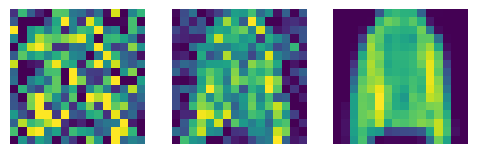

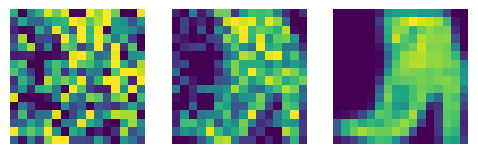

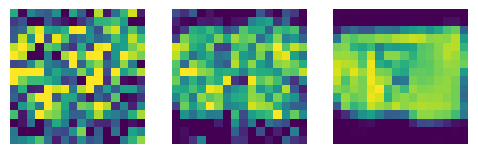

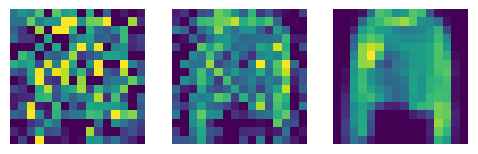

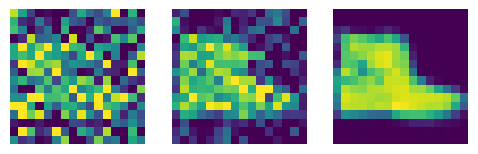

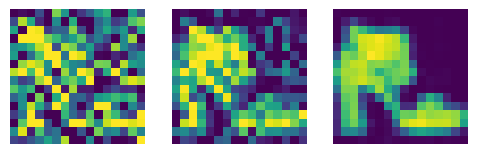

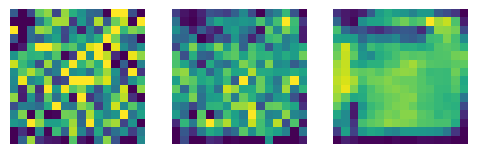

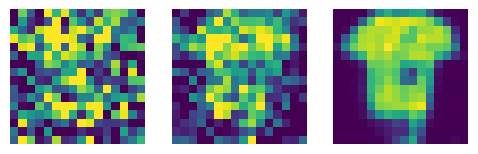

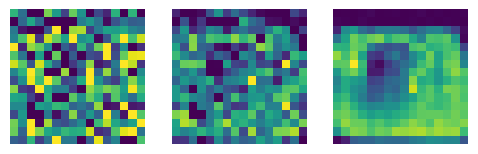

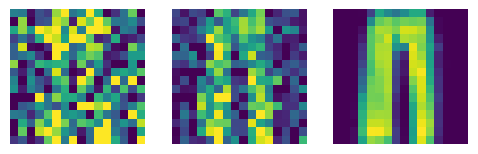

In [17]:
model.eval()
plt.figure(figsize=(8,8))
ncols = 3 # Should evenly divide T
for _ in range(10):
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)